<a href="https://colab.research.google.com/github/alexcontarino/personal-projects/blob/main/Sports_Betting/Market_Driven_Power_Rankings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uses the dataframe created by "NFL Moneyline Scrape" to create a power ranking of NFL teams. Rankings are determined by estimating each team's spread against an average team on a neutral field.  

Very much inspired by Ben Baldwin's ("X": @benbbaldwin) in-season market-derived team tier updates.

Example: https://x.com/benbbaldwin/status/1849088175500656732

# Set-Up

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pickle
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gamelines = pd.read_csv("drive/MyDrive/2025_gamelines.csv")
gamelines.head()

,away,home,home_spread,away_line,home_line,away_prob,home_prob
0,Cowboys,Eagles,-7.0,+260,−325,0.266458,0.733542
1,Chiefs,Chargers,3.0,−148,+124,0.572060,0.427940
2,Bengals,Browns,5.5,−230,+190,0.669007,0.330993
3,Giants,Commanders,-7.0,+230,−285,0.290456,0.709544
4,Cardinals,Saints,5.5,−238,+195,0.675031,0.324969


# Compute Power Rankings

Create linear regression model
- Output: Predicted home team spread
- Input: Away team and home team

Goal: Use away and home coefficients of each team to calculate (simple average) their power ranking: spread against avg team on neutral field

In [4]:
teams = gamelines.away.unique()

In [5]:
# Create data frame of indicator variables for each instance of a team playing at home or away
cols = []
for team in teams:
  for location in ["away", "home"]:
    cols.append(team + "_" + location)

cols.append("home_spread")

model_df = pd.DataFrame(index=range(16*17), columns=cols)

row = 0
for game in gamelines.iterrows():
  away_team = game[1].away
  home_team = game[1].home
  home_spread = game[1].home_spread
  model_df.loc[row, away_team + "_away"] = 1
  model_df.loc[row, home_team + "_home"] = 1
  model_df.loc[row, "home_spread"] = home_spread
  row += 1

model_df = model_df.fillna(0)

<ipython-input-5-5b5611d12e81>:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_df = model_df.fillna(0)


In [6]:
model_df.head()

,Cowboys_away,Cowboys_home,Chiefs_away,Chiefs_home,Bengals_away,Bengals_home,Giants_away,Giants_home,Cardinals_away,Cardinals_home,...,Chargers_home,Jets_away,Jets_home,Packers_away,Packers_home,Colts_away,Colts_home,Saints_away,Saints_home,home_spread
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-7.0
1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3.0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.5
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,-7.0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,5.5


In [7]:
# input and output variables
x = model_df.drop("home_spread", axis=1)
y = model_df.home_spread

In [8]:
# fit regression model
model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [9]:
# Compute R-Squared
model.score(x, y)

0.9838313753230565

In [10]:
# Compute power ranking: take average of each team's away and home coefficient
team_coef = pd.DataFrame(model.coef_.reshape(1,-1), index = [0], columns = list(x.columns))

team_power_rankings = pd.DataFrame(index = range(32), columns=["Team", "Predicted Spread"])

row = 0
for team in teams:
  # average of home and away coefficients (stronger team = negative spread --> "substracting" home spread s.t. stronger team = positive value)
  pred_spread = (team_coef.loc[0, team + "_away"] - team_coef.loc[0, team + "_home"]) / 2
  team_power_rankings.loc[row, "Team"] = team
  team_power_rankings.loc[row, "Predicted Spread"] = round(pred_spread,2)
  row+=1

# Sort values
team_power_rankings = team_power_rankings.sort_values("Predicted Spread", ascending=False)
team_power_rankings["Power Ranking"] = range(1,33)
team_power_rankings.set_index("Power Ranking", inplace=True)


# Power Rankings

In [11]:
team_power_rankings

,Team,Predicted Spread
Power Ranking,,
1,Eagles,5.53
2,Ravens,5.52
3,Bills,5.11
4,Chiefs,5.1
5,Lions,3.68
6,Commanders,3.02
7,Packers,2.63
8,Broncos,2.34
9,49ers,2.11


# Appendix

Potential future projects for future use  

## Clustering

Cluster teams to identify like-groups  

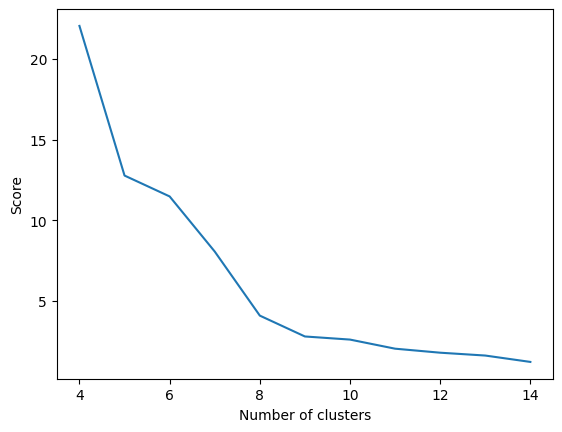

In [12]:
from sklearn.cluster import KMeans

x = team_power_rankings["Predicted Spread"].values.reshape(-1,1)

clusters = range(4,15)
scores = []
for n_cluster in clusters:

  kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(x)
  scores.append(-kmeans.score(x))

plt.plot(clusters, scores)
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.show()

In [13]:
# Let's do 8!
best_n_cluster = 8

kmeans = KMeans(n_clusters=best_n_cluster, random_state=0).fit(x)

groups = kmeans.predict(x)

team_power_rankings["group"] = groups

team_power_rankings

,Team,Predicted Spread,group
Power Ranking,,,
1,Eagles,5.53,3
2,Ravens,5.52,3
3,Bills,5.11,3
4,Chiefs,5.1,3
5,Lions,3.68,1
6,Commanders,3.02,1
7,Packers,2.63,1
8,Broncos,2.34,4
9,49ers,2.11,4


## Spread to Win Probability

Identify relationship between spread and moneyline.

Next steps once season starts. During the season, gamelines are only offered for next 2 weeks / no longer for entire season.

1. Update rankings according to in-season spreads
1. Predict spread for future games using updated rankings
1. Predict win probabilities using predicted spreads
1. Simulate remainder of season using predicted win probabilities
1. Calculate avg wins, win distribution #s, and playoff probabilities

In [14]:
def logit(p):

  return np.log(p/(1-p))

In [15]:
def logistic(logit):

  return 1/(1+np.exp(-logit))

In [16]:
# transform estimated home win probability with logit function
# Predict transformed values using home spread value
y = logit(gamelines.home_prob.values).reshape(-1,1)
x = gamelines.home_spread.values.reshape(-1,1)

In [17]:
# Fit model
win_prob_model = LinearRegression()
win_prob_model.fit(x, y)

LinearRegression()

In [18]:
# Save model
with open('drive/MyDrive/win_prob_by_home_spread.pkl', 'wb') as f:
    pickle.dump(win_prob_model, f)

In [19]:
# Compute predicted values
y_pred_raw = win_prob_model.predict(x)
y_pred = logistic(y_pred_raw)

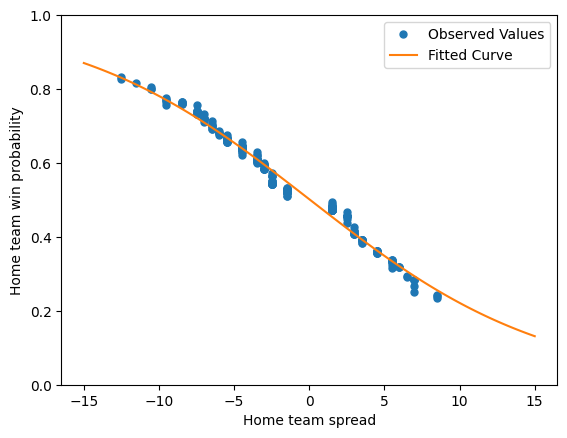

In [20]:
# Plot values
plt.plot(gamelines.home_spread, gamelines.home_prob, 'o', label="Observed Values", markersize=5)

#x_plot = np.linspace(min(gamelines.home_spread), max(gamelines.home_spread), 100)
x_plot = np.linspace(-15, 15, 100)
y_plot = logistic(win_prob_model.predict(x_plot.reshape(-1,1)))
plt.plot(x_plot, y_plot, label="Fitted Curve")

plt.ylim([0,1])
plt.legend()
plt.xlabel("Home team spread")
plt.ylabel("Home team win probability")
plt.show()